# AWS Access

A growing number of CORDEX datasets is now available from AWS S3. In this examples, we will show how to access the datasets using an ESM collection and derive an ensemble mean.

In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Workers: 9
Total threads: 54,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42207,Workers: 9
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Total threads: 54
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:44177,Total threads: 6
Dashboard: /user/g300046/levante-spawner-preset//proxy/38813/status,Memory: 11.11 GiB
Nanny: tcp://127.0.0.1:39569,


In [2]:
import cf_xarray as cfxr
import fsspec
import intake
import xarray as xr

url = "https://euro-cordex.s3.eu-central-1.amazonaws.com/catalog/CORDEX-CMIP5.json"
cat = intake.open_esm_datastore(url)

In [3]:
cat

,unique
project_id,1
product,1
CORDEX_domain,1
institute_id,12
driving_model_id,10
experiment_id,5
member,4
model_id,13
rcm_version_id,4
frequency,1


In [4]:
cat.df.head()

,project_id,product,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,variable_id,version,path
0,cordex,output,EUR-11,CLMcom-ETH,MPI-M-MPI-ESM-LR,historical,r1i1p1,COSMO-crCLIM-v1-1,v1,mon,tas,v20191219,s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
1,cordex,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,RCA4,v1,mon,tas,v20131026,s3://euro-cordex/CMIP5/cordex/output/EUR-11/SM...
2,cordex,output,EUR-11,CLMcom-ETH,CNRM-CERFACS-CNRM-CM5,rcp85,r1i1p1,COSMO-crCLIM-v1-1,v1,mon,tas,v20210430,s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
3,cordex,output,EUR-11,KNMI,ICHEC-EC-EARTH,historical,r3i1p1,RACMO22E,v1,mon,tas,v20190108,s3://euro-cordex/CMIP5/cordex/output/EUR-11/KN...
4,cordex,output,EUR-11,DMI,CNRM-CERFACS-CNRM-CM5,rcp85,r1i1p1,HIRHAM5,v2,mon,tas,v20190208,s3://euro-cordex/CMIP5/cordex/output/EUR-11/DM...


We can open a single datasets from S3 by using the URL from data dataframe, e.g., to look at

In [5]:
cat.df.iloc[0]

project_id                                                     cordex
product                                                        output
CORDEX_domain                                                  EUR-11
institute_id                                               CLMcom-ETH
driving_model_id                                     MPI-M-MPI-ESM-LR
experiment_id                                              historical
member                                                         r1i1p1
model_id                                            COSMO-crCLIM-v1-1
rcm_version_id                                                     v1
frequency                                                         mon
variable_id                                                       tas
version                                                     v20191219
path                s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
Name: 0, dtype: object

we can open this dataset using xarray with zarr

In [6]:
ds = xr.open_zarr(
    store=fsspec.get_mapper(cat.df.iloc[0].path, anon=True), consolidated=True
)
ds

<xarray.Dataset>
Dimensions:       (rlat: 412, rlon: 424, time: 684, bnds: 2)
Coordinates:
    height        float64 ...
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 -23.38 -23.26 -23.16 ... 21.61 21.73 21.83
  * rlon          (rlon) float64 -28.38 -28.26 -28.16 ... 17.93 18.05 18.16
  * time          (time) datetime64[ns] 1949-01-16T12:00:00 ... 2005-12-16T12...
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  |S1 ...
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(143, 412, 424), meta=np.ndarray>
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(143, 2), meta=np.ndarray>
Attributes: (12/26)
    CORDEX_domain:                  EUR-11
    Conventions:                    CF-1.4
    c3s_disclaimer:                 This data has been produced in the contex...
    comment:                        Please use the following reference for th...
    config_cclm:                    EUR-11_CLMcom-ETH-COSMO-crCLIM-v1-1_01_co...
    config_int2lm:                  EUR-11_int2lm2.5.1_01_config
    ...                             ...
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     http://cordex.clm-community.eu/
    source:                         Climate Limited-area Modelling Community ...
    title:                          CLMcom-ETH-COSMO-crCLIM-v1-1 model output...
    tracking_id:                    151e60a4-e4c0-11e9-a214-d09466354597

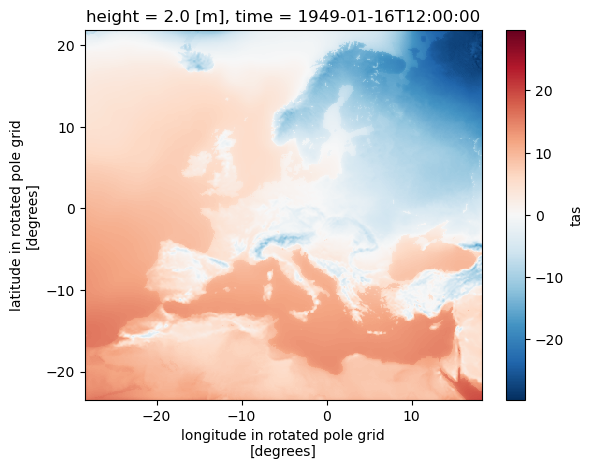

In [7]:
(ds.tas.isel(time=0) - 273.5).plot()

In [8]:
ds.close()

## Open an ESM collection

We can also use intake to open a collection of datasets into a dictionary. E.g., to open up all 2m temperature datasets, we search for them in the catalog:

In [9]:
subset = cat.search(variable_id="tas", experiment_id=['historical', 'rcp26', 'rcp45', 'rcp85'])
subset

,unique
project_id,1
product,1
CORDEX_domain,1
institute_id,11
driving_model_id,9
experiment_id,4
member,4
model_id,12
rcm_version_id,4
frequency,1


In [11]:
dsets = subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    storage_options={"anon": True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.CORDEX_domain.institute_id.driving_model_id.experiment_id.member.model_id.rcm_version_id.frequency'


There are different numbers of datsets for each scenario. For later computations, it's useful to sort those datasets out. We will also combine scenario data with historical data so we can make a running mean easily.

In [12]:
from collections import defaultdict

import tqdm


def sort_datasets(dsets):
    """sort datasets by scenario and append historical data"""
    results = defaultdict(dict)
    for dset_id, ds in tqdm.tqdm(dsets.items()):
        exp_id = dset_id.split(".")[4]
        new_id = dset_id.replace(f"{exp_id}.", "")
        # collect historical
        if exp_id == "historical":
            results[exp_id][new_id] = ds
            continue
        # if scenario, look for corresponding historical data
        # and concat if historical is available
        hist_id = dset_id.replace(exp_id, "historical")
        if hist_id not in dsets.keys():
            print(f"historical not found: {hist_id}")
            continue
            #results[exp_id][new_id] = v
        else:
            results[exp_id][new_id] = xr.concat([dsets[hist_id][['tas']], ds[['tas']]], dim="time")
    return results
        

dsets_sorted = sort_datasets(dsets)

 15%|█▍        | 24/165 [00:14<00:56,  2.50it/s]

historical not found: cordex.EUR-11.GERICS.MOHC-HadGEM2-ES.historical.r1i1p1.REMO2015.v1.mon


 30%|██▉       | 49/165 [00:25<00:54,  2.13it/s]

historical not found: cordex.EUR-11.GERICS.MOHC-HadGEM2-ES.historical.r1i1p1.REMO2015.v1.mon


 41%|████      | 68/165 [00:34<00:43,  2.21it/s]

historical not found: cordex.EUR-11.GERICS.ICHEC-EC-EARTH.historical.r12i1p1.REMO2015.v1.mon


 54%|█████▍    | 89/165 [00:40<00:24,  3.08it/s]

historical not found: cordex.EUR-11.GERICS.MIROC-MIROC5.historical.r1i1p1.REMO2015.v1.mon


 65%|██████▍   | 107/165 [00:47<00:21,  2.65it/s]

historical not found: cordex.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.historical.r1i1p1.ALADIN53.v1.mon


 73%|███████▎  | 120/165 [00:53<00:26,  1.72it/s]

historical not found: cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.historical.r1i1p1.WRF361H.v1.mon


 86%|████████▌ | 142/165 [01:01<00:10,  2.21it/s]

historical not found: cordex.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.historical.r1i1p1.ALADIN53.v1.mon


 92%|█████████▏| 152/165 [01:05<00:04,  2.69it/s]

historical not found: cordex.EUR-11.CLMcom.MIROC-MIROC5.historical.r1i1p1.CCLM4-8-17.v1.mon


100%|██████████| 165/165 [01:09<00:00,  2.37it/s]


Let's check out a yearly rolling mean of a single dataset:

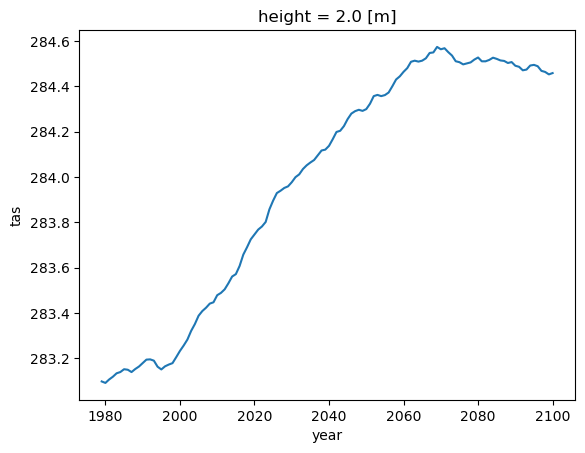

In [21]:
dsets_sorted['rcp26']['cordex.EUR-11.CLMcom.ICHEC-EC-EARTH.r12i1p1.CCLM4-8-17.v1.mon'].sel(time=slice("1950", "2100")).groupby("time.year").mean().cf.mean(('X', 'Y')).rolling(year=30).mean().tas.plot()

Let's do it for the whole ensemble!

In [21]:
xr.set_options(keep_attrs=True) 


def yearly_mean(ds):
    """compute yearly mean for one dataset"""
    return ds.sel(time=slice("1950", "2100")).groupby("time.year").mean().cf.mean(('X', 'Y'))


def ensemble_mean(dsets):
    """compute ensemble yearly mean"""
    return xr.concat([yearly_mean(ds.tas) for ds in dsets.values()], dim=xr.DataArray(list(dsets.keys()), dims="dset_id"), coords="minimal", compat="override")
    

We create a dictionary of ensemble means for each scenario:

In [22]:
%time ensembles = {exp_id: ensemble_mean(dsets).compute() for exp_id, dsets in dsets_sorted.items()}

CPU times: user 1min 17s, sys: 3.97 s, total: 1min 21s
Wall time: 2min 21s


In [23]:
ensemble = xr.concat(list(ensembles.values()), dim=xr.DataArray(list(ensembles.keys()), dims="experiment_id"))

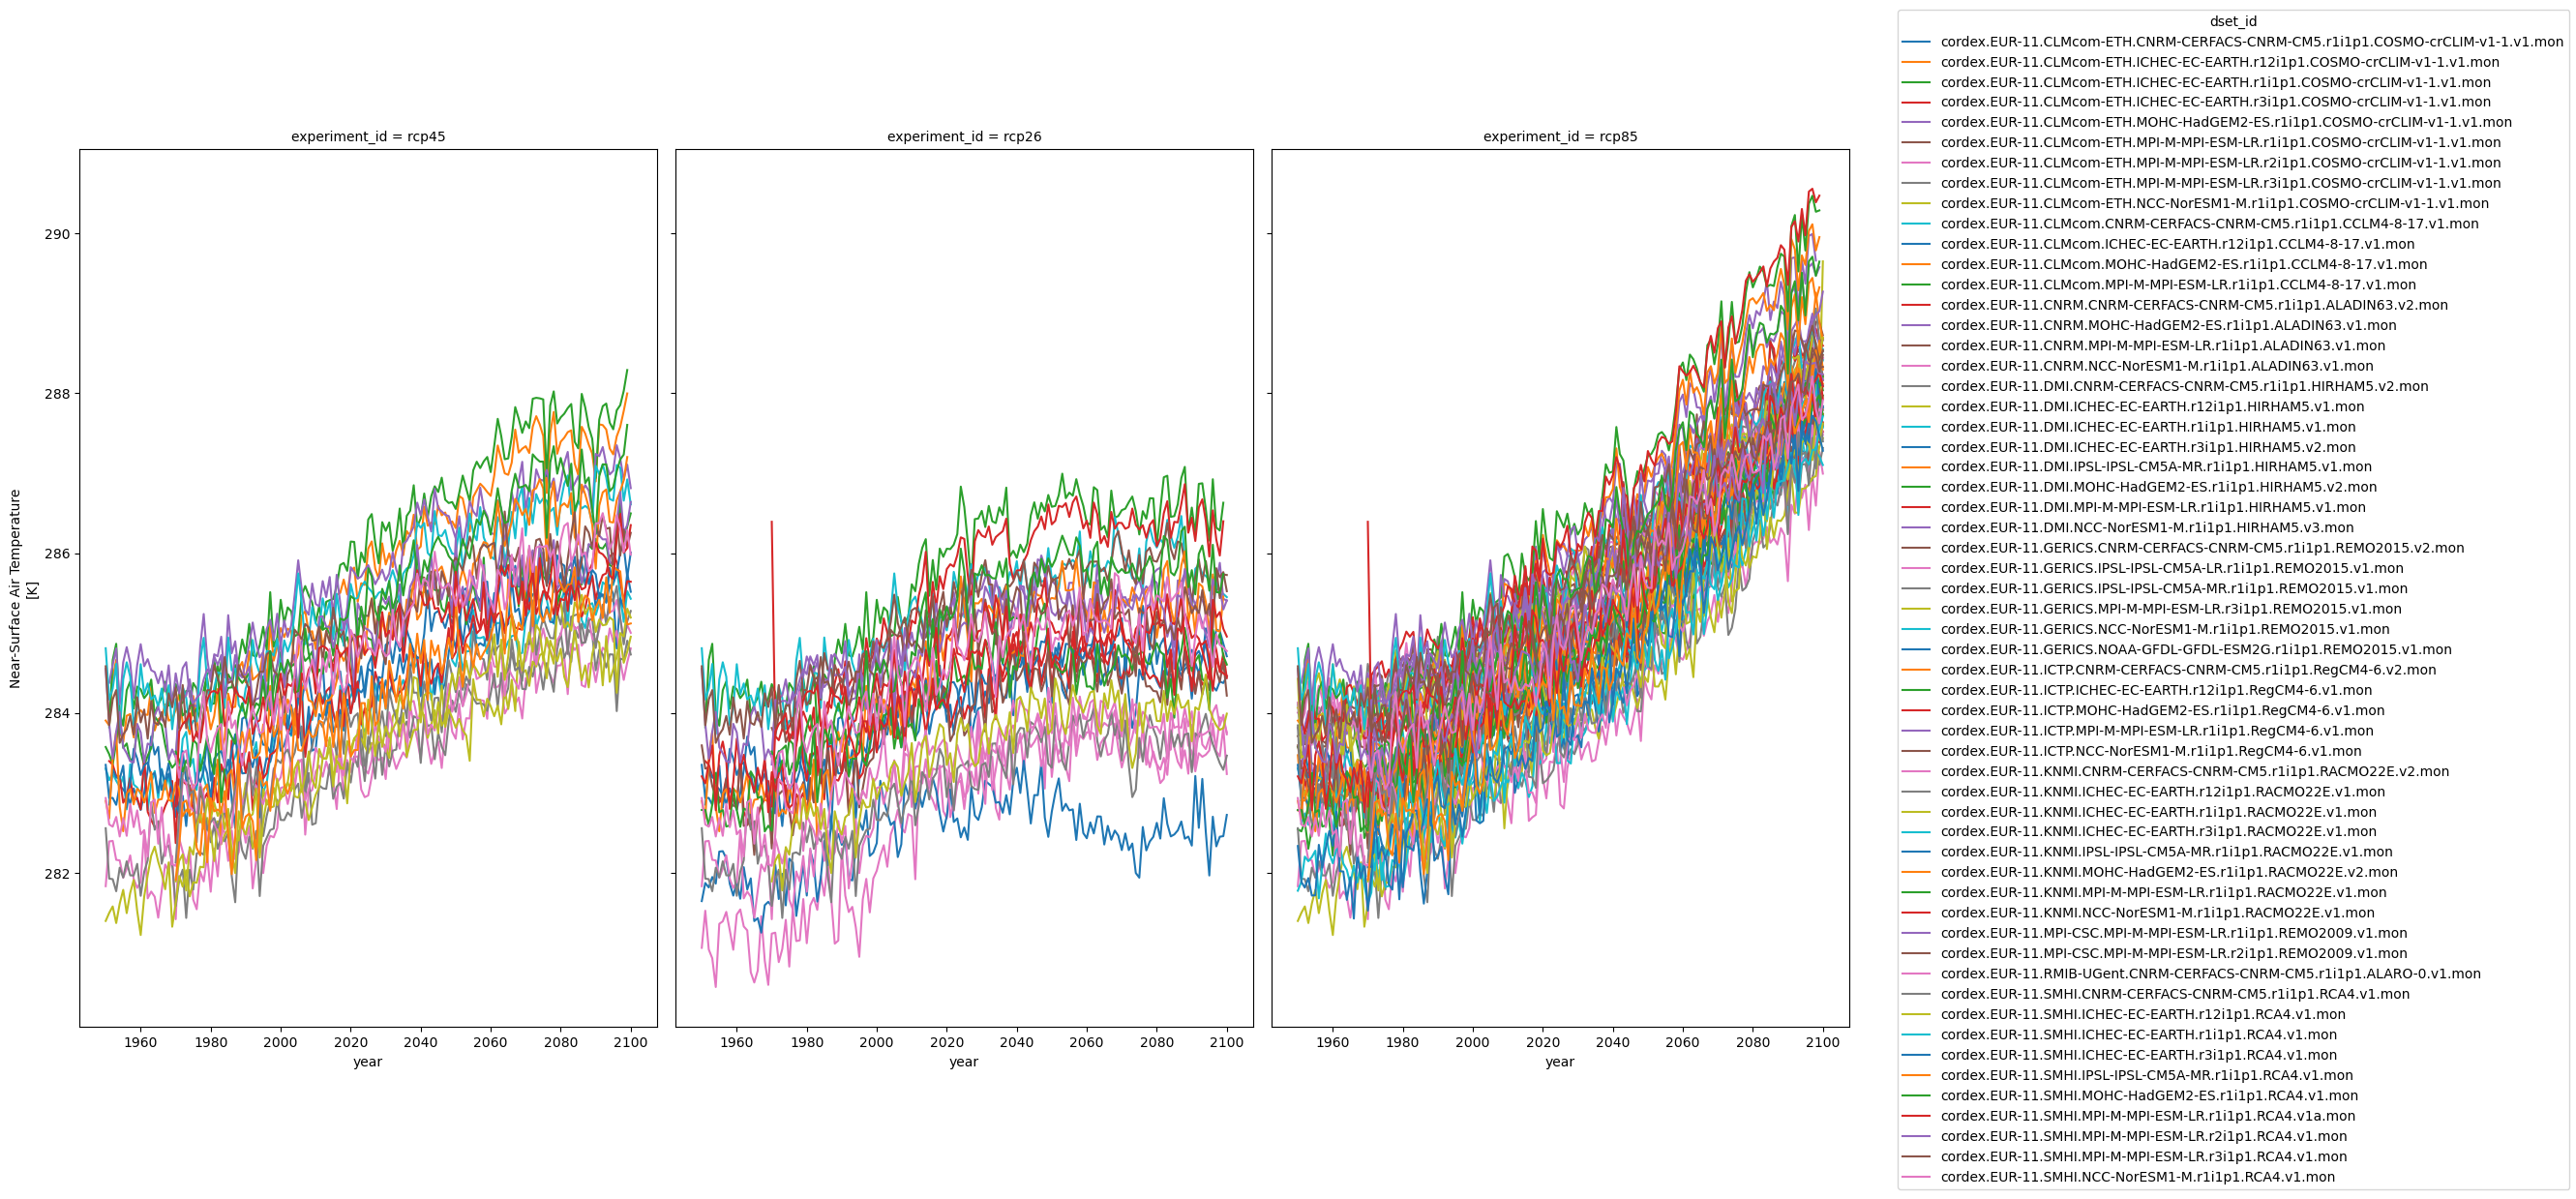

In [24]:
ensemble.plot(col="experiment_id", hue="dset_id", figsize=(20,10))

In [25]:
df = ensemble.to_dataframe().reset_index()
df

,experiment_id,dset_id,year,height,tas
0,rcp45,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1950,2.0,NaN
1,rcp45,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1951,2.0,NaN
2,rcp45,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1952,2.0,NaN
3,rcp45,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1953,2.0,NaN
4,rcp45,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1954,2.0,NaN
...,...,...,...,...,...
25816,rcp85,cordex.EUR-11.SMHI.NCC-NorESM1-M.r1i1p1.RCA4.v...,2096,2.0,287.916962
25817,rcp85,cordex.EUR-11.SMHI.NCC-NorESM1-M.r1i1p1.RCA4.v...,2097,2.0,288.212250
25818,rcp85,cordex.EUR-11.SMHI.NCC-NorESM1-M.r1i1p1.RCA4.v...,2098,2.0,287.801270
25819,rcp85,cordex.EUR-11.SMHI.NCC-NorESM1-M.r1i1p1.RCA4.v...,2099,2.0,287.623718


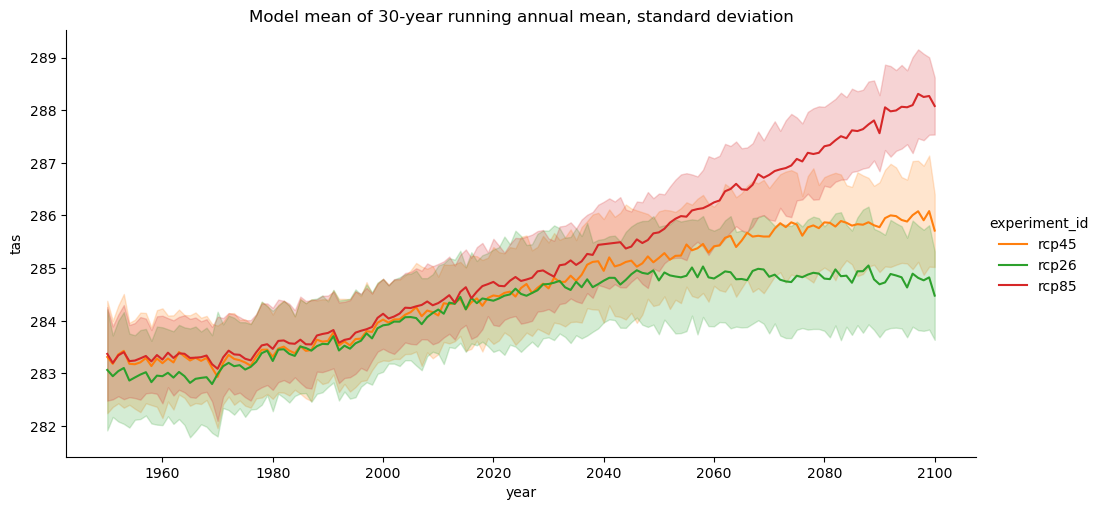

In [26]:
import seaborn as sns

palette = {"rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(
    data=df[(df["year"] >= 1950) & (df["year"] <= 2100)],
    x="year",
    y="tas",
    hue="experiment_id",
    kind="line",
    errorbar="sd",
    aspect=2,
    palette=palette,
)
g.set(title="Model mean of 30-year running annual mean, standard deviation")